In [1]:
from ambientperiod.builder.build_period import BuildPeriod


import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from ambientperiod.analysis.sua_vent import show_smoothing_example

show_smoothing_example()


In [ ]:


# Set the font family and size
plt.rcParams['font.family'] = 'arial'
plt.rcParams['font.size'] = 10 
plt.rcParams['font.stretch'] = 'condensed'

In [7]:


filename = r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\09. Cluster\01. Senales\20230604235313.h5'
print(f"Showing {filename=}")
dataset = h5py.File(filename)


def read_acceleration_data(filename,factor):
    dataset = h5py.File(filename)
    acc1 = factor * (dataset["/Devices/MNAT0031/Acceleration"][:] - np.mean(dataset["/Devices/MNAT0031/Acceleration"][:], axis=0))
    acc2 = factor * (dataset["/Devices/MNAT0034/Acceleration"][:] - np.mean(dataset["/Devices/MNAT0034/Acceleration"][:], axis=0))
    dataset.close()
    return acc1, acc2

factor = 15.625e-6
# factor = 1.0
acc1,acc2 = read_acceleration_data(filename,factor)



Showing filename='C:\\Users\\ppala\\OneDrive\\01. Brain\\10. Ph.D U ANDES\\09. Cluster\\01. Senales\\20230604235313.h5'


In [ ]:

# Configuration (defined here instead of a config.py)
config = {
    "Fs": 250,                          # % Frecuencia de muestreo
    "vent": 100,                         # % Duracion de las ventanas
    'vent_seismic': False,
    "STA": 1,       "LTA": 30,          # % Algoritmo STA/LTA
    "vmin": 0.7,    "vmax": 1.4,        # % Limites algoritmo STA/LTA
    "p": 0.05,                          # % R para tapper de ventana
    "f1": 0.5,      "f2": 50.0,         # % Límites de ancho de banda de frecuencia     
    "bexp": 80                          # % Constante de suavizado (Konno & Ohmachi 1998)
}

N=len(acc1)
builder_X = BuildPeriod(acc1[:N//10], config , display_figures=True)
builder_Y = BuildPeriod(acc2[:N//10], config , display_figures=True)


In [ ]:
aaa=ppp*2

In [ ]:

builders = [
    (builder_X, builder_Y),
]


from ambientperiod.tools.plot_common_windows import plot_common_windows
plot_common_windows(builders)

from ambientperiod.tools.plot_common_spectra import plot_common_spectra
plot_common_spectra(builders)

from ambientperiod.tools.plot_H_V_common_windows import plot_H_V_common_windows
plot_H_V_common_windows(builders , peak_spacing_hz=0.2, numer_peaks=3, min_freq=0.1 )

In [ ]:
ppp

In [ ]:
# Configuration (defined here instead of a config.py)
config = {
    "Fs": 244,                          # % Frecuencia de muestreo
    "vent": 30,                         # % Duracion de las ventanas
    'vent_seismic': False,
    "STA": 1,       "LTA": 30,          # % Algoritmo STA/LTA
    "vmin": 0.1,    "vmax": 3.5,        # % Limites algoritmo STA/LTA
    "p": 0.05,                          # % R para tapper de ventana
    "f1": 0.01,      "f2": 50.0,         # % Límites de ancho de banda de frecuencia     
    "bexp": 40                          # % Constante de suavizado (Konno & Ohmachi 1998)
}

signal_path = r'C:\Users\ppala\OneDrive\01. Brain\11. GitHub\AmbientSoilPeriod\signals\TS01.txt'
builder = BuildPeriod(signal_path, config , display_figures=False)

In [ ]:
ppp

C:\Users\ppala\AppData\Local\Temp\ipykernel_259280\3520621228.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


--------------------------------------------------
INICIALIZATION
--------------------------------------------------
Signal provided directly as array.
algorithm_sta_lta OK...


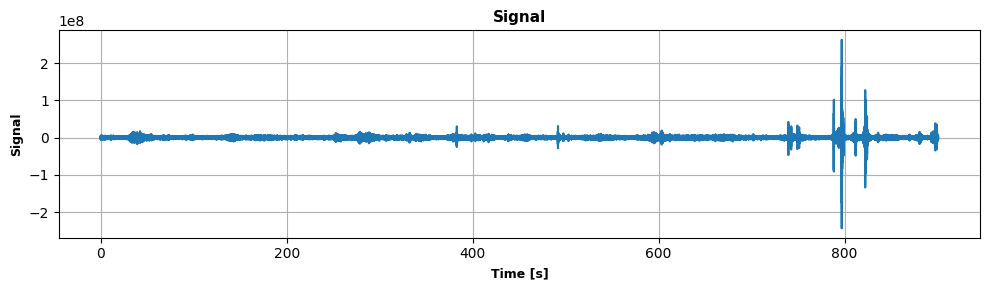

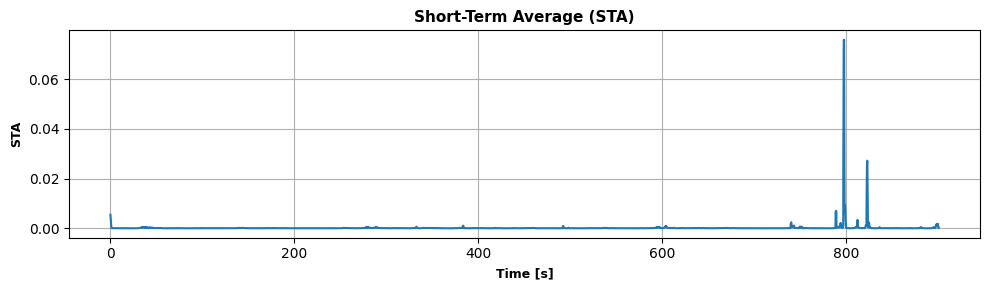

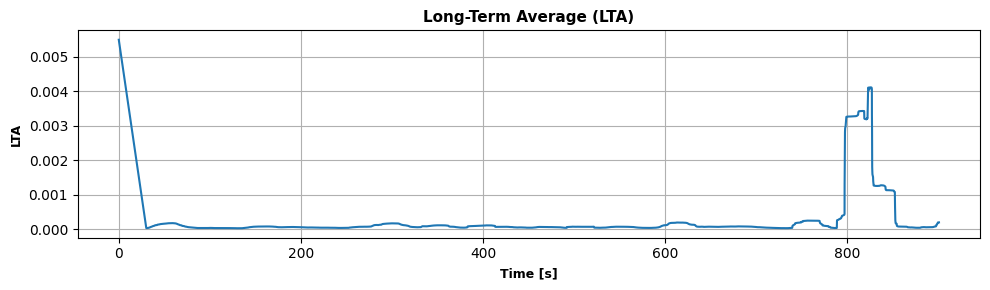

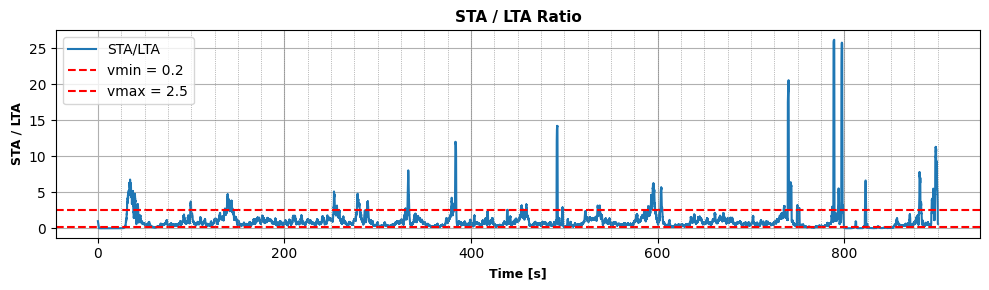

plot_sta_lta OK...
window_selector OK...


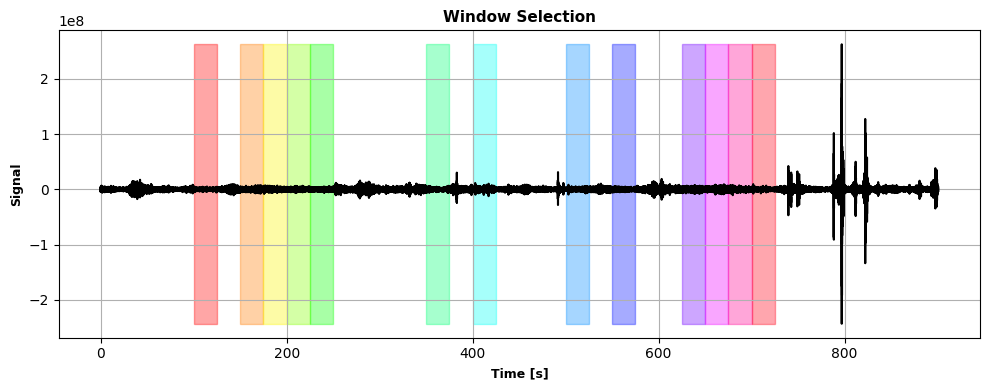

plot_selected_windows OK...
taper_function OK...
plot_tapper OK...
compute_fft OK...
sua_vent OK...
prom_vent OK...


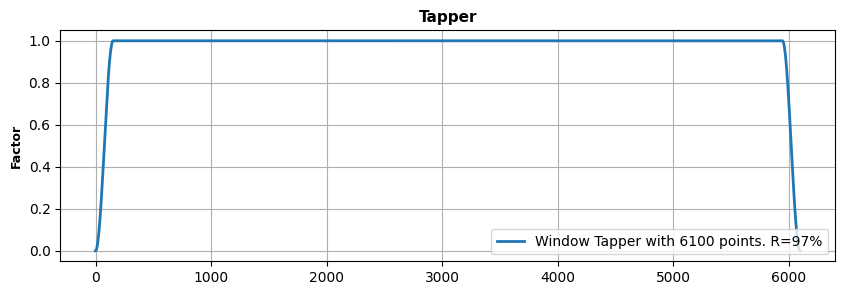

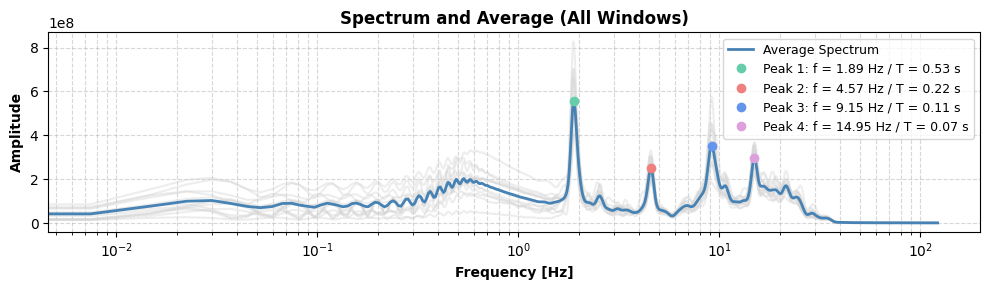

prom_vent OK...
--------------------------------------------------
INICIALIZATION
--------------------------------------------------
Signal provided directly as array.
algorithm_sta_lta OK...


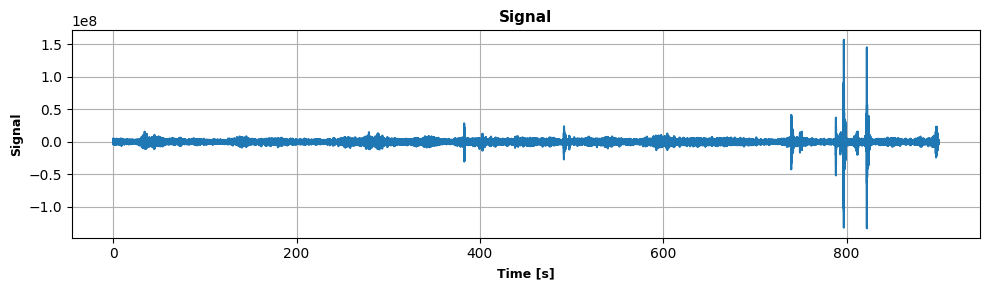

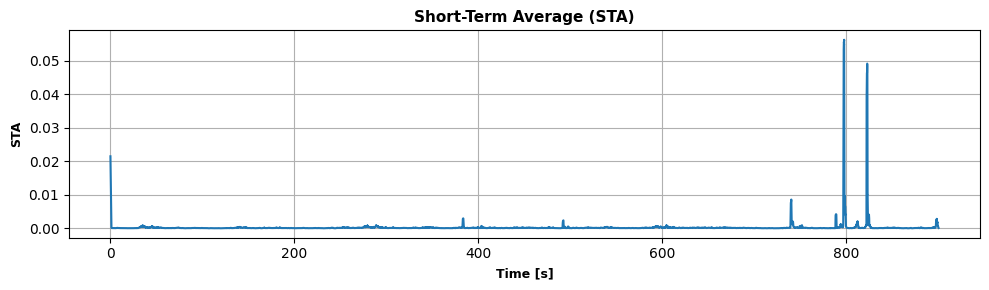

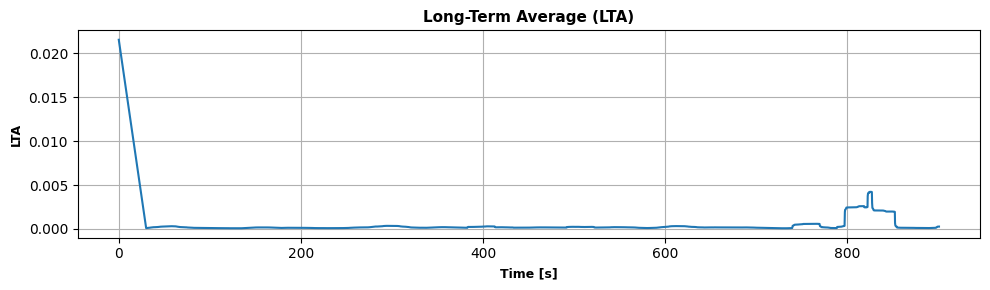

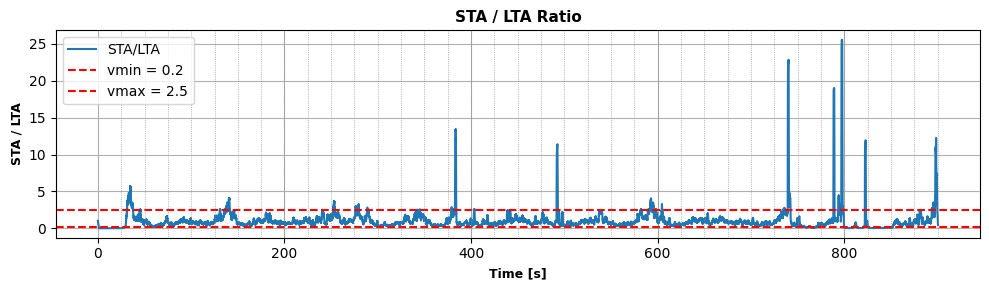

plot_sta_lta OK...
window_selector OK...


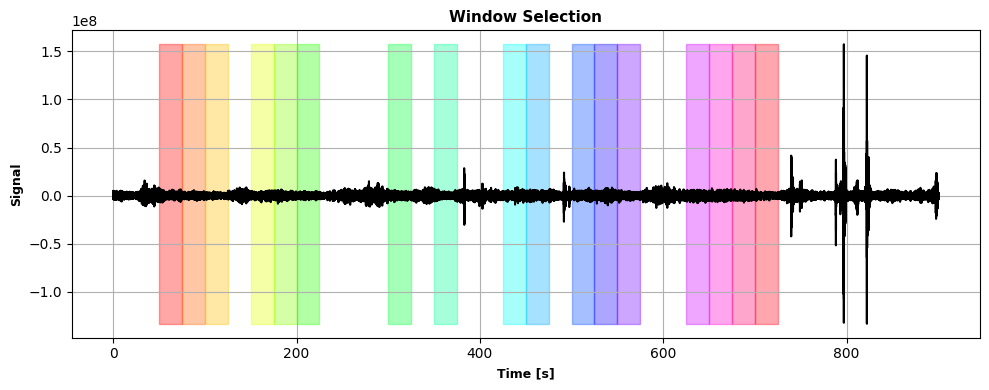

plot_selected_windows OK...
taper_function OK...
plot_tapper OK...
compute_fft OK...
sua_vent OK...
prom_vent OK...


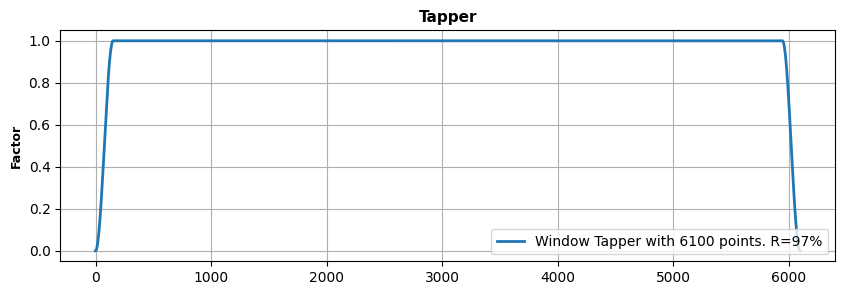

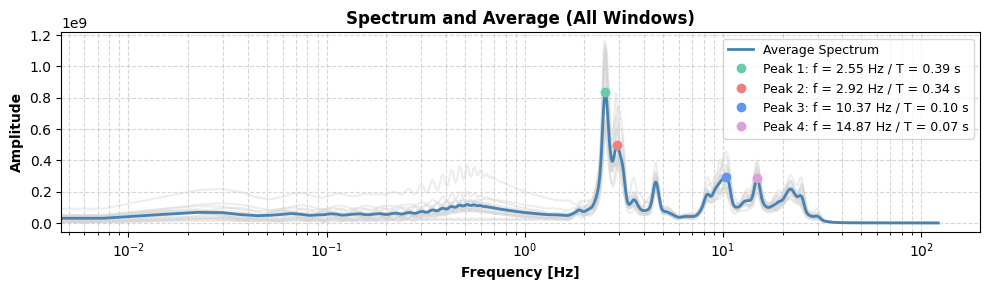

prom_vent OK...
--------------------------------------------------
INICIALIZATION
--------------------------------------------------
Signal provided directly as array.
algorithm_sta_lta OK...


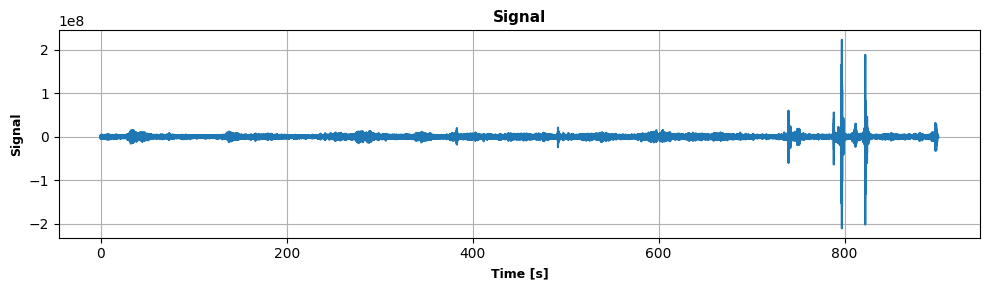

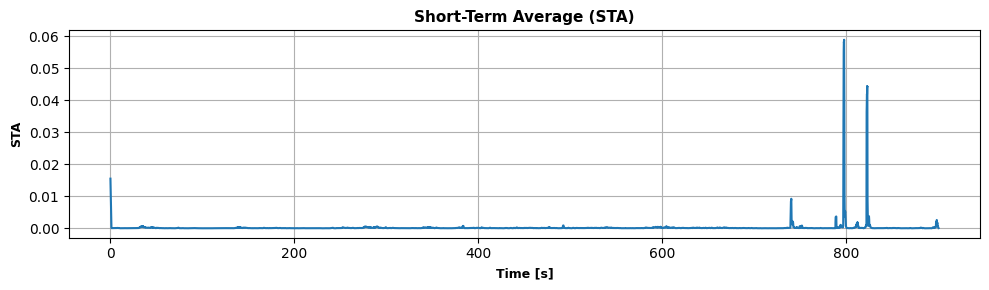

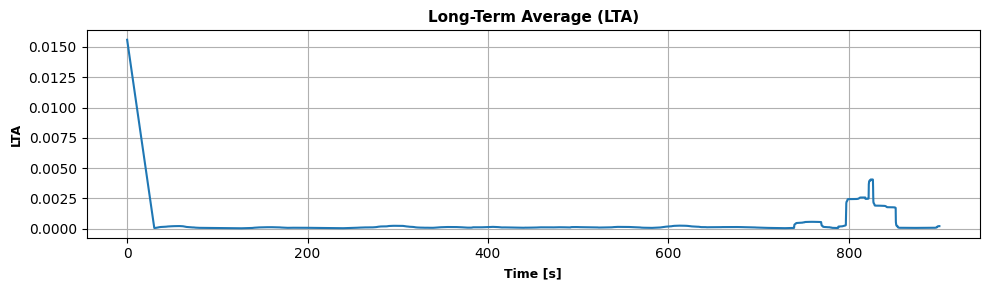

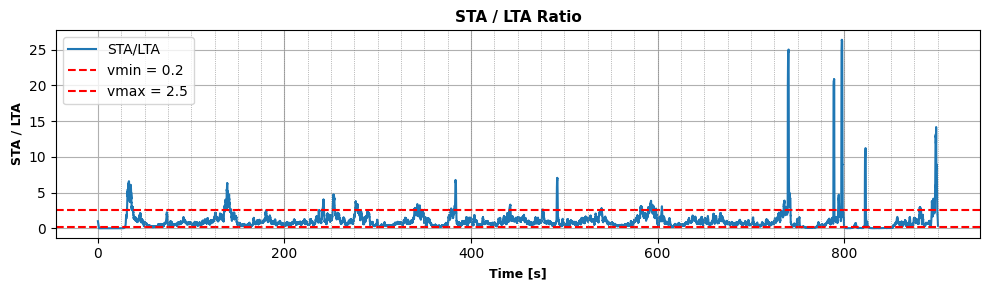

plot_sta_lta OK...
window_selector OK...


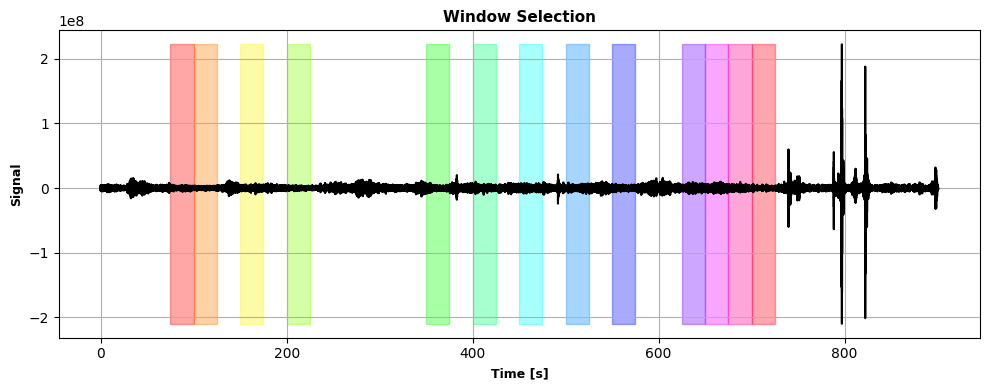

plot_selected_windows OK...
taper_function OK...
plot_tapper OK...
compute_fft OK...
sua_vent OK...
prom_vent OK...


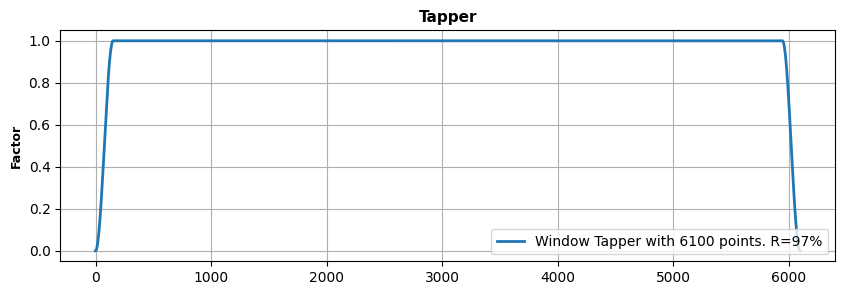

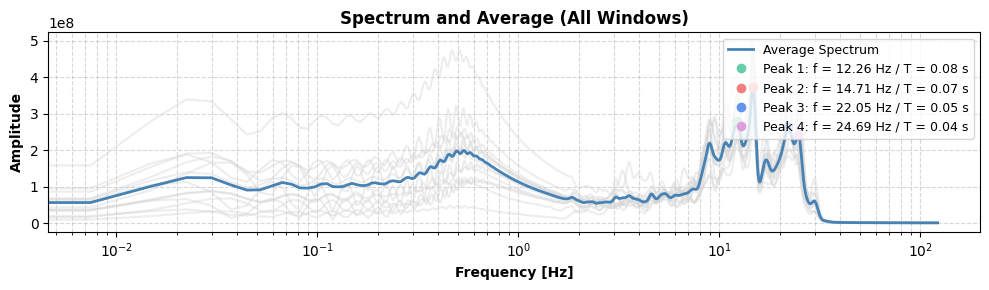

prom_vent OK...


In [5]:
df = pd.read_csv(
    r'C:\Users\ppala\OneDrive\01. Brain\01. Consultorias\048. Reforzamiento San Gabriel\04. Larzé\MedicionesSanGabriel\TorreNorte\Setup1_sensor1.txt',
    delim_whitespace=True,
    header=None,
    skiprows=14,
    engine='python'
)

accel1 = df.iloc[:, 0].values
accel2 = df.iloc[:, 1].values
accel3 = df.iloc[:, 2].values


# accel1 = df.iloc[:, 3].values
# accel2 = df.iloc[:, 4].values
# accel3 = df.iloc[:, 5].values




# Configuration (defined here instead of a config.py)
config = {
    "Fs": 244,                          # % Frecuencia de muestreo
    "vent": 25,                         # % Duracion de las ventanas
    'vent_seismic': False, 
    "STA": 1,       "LTA": 30,          # % Algoritmo STA/LTA
    "vmin": 0.2,    "vmax": 2.5,        # % Limites algoritmo STA/LTA
    "p": 0.05,                          # % R para tapper de ventana
    "f1": 0.5,      "f2": 25.0,         # % Límites de ancho de banda de frecuencia     
    "bexp": 80                          # % Constante de suavizado (Konno & Ohmachi 1998)
}

builder_X = BuildPeriod(accel1, config , display_figures=True)

builder_Y = BuildPeriod(accel2, config , display_figures=True)

builder_Z = BuildPeriod(accel3, config , display_figures=True)


In [ ]:
# Configuration (defined here instead of a config.py)
config = {
    "Fs": 244,                          # % Frecuencia de muestreo
    "vent": 25,                         # % Duracion de las ventanas
    'vent_seismic': False, 
    "STA": 1,       "LTA": 30,          # % Algoritmo STA/LTA
    "vmin": 0.2,    "vmax": 2.5,        # % Limites algoritmo STA/LTA
    "p": 0.05,                          # % R para tapper de ventana
    "f1": 0.5,      "f2": 25.0,         # % Límites de ancho de banda de frecuencia     
    "bexp": 80                          # % Constante de suavizado (Konno & Ohmachi 1998)
}

signal_path = r'C:\Users\ppala\OneDrive\01. Brain\11. GitHub\AmbientSoilPeriod\signals\Suelo02_Ax01.txt'
builder_X = BuildPeriod(signal_path, config , display_figures=True)

signal_path = r'C:\Users\ppala\OneDrive\01. Brain\11. GitHub\AmbientSoilPeriod\signals\Suelo02_Ay01.txt'
builder_Y = BuildPeriod(signal_path, config , display_figures=True)

signal_path = r'C:\Users\ppala\OneDrive\01. Brain\11. GitHub\AmbientSoilPeriod\signals\Suelo02_Az01.txt'
builder_Z = BuildPeriod(signal_path, config , display_figures=True)


In [ ]:
builders = [
    (builder_X, builder_Y, builder_Z),
]

from ambientperiod.tools.plot_common_windows import plot_common_windows
plot_common_windows(builders)

from ambientperiod.tools.plot_common_spectra import plot_common_spectra
plot_common_spectra(builders)

from ambientperiod.tools.plot_H_V_common_windows import plot_H_V_common_windows
plot_H_V_common_windows(builders , peak_spacing_hz=0.2, numer_peaks=3, min_freq=0.1 )

In [ ]:
ppp

In [ ]:
# Configuration (defined here instead of a config.py)
config = {
    "Fs": 50.0,                          # % Frecuencia de muestreo
    "vent": 10,                         # % Duracion de las ventanas
    "STA": 5,       "LTA": 30,          # % Algoritmo STA/LTA
    "vmin": 0.01,    "vmax": 5.5,        # % Limites algoritmo STA/LTA
    "p": 0.05,                          # % R para tapper de ventana
    "f1": 1.0,      "f2": 20.0,         # % Límites de ancho de banda de frecuencia     
    "bexp": 40                          # % Constante de suavizado (Konno & Ohmachi 1998)
}

df = pd.read_csv(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\sismos\98-10-16\98-10-16-sup-ns.txt', delim_whitespace=True, header=None, skiprows=1)
signal_path = df[1].values

builder_X = BuildPeriod(signal_path, config , display_figures=False)


df = pd.read_csv(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\sismos\98-10-16\98-10-16-sup-ew.txt', delim_whitespace=True, header=None, skiprows=1)
signal_path = df[1].values
builder_Y = BuildPeriod(signal_path, config , display_figures=False)


df = pd.read_csv(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\sismos\98-10-16\98-10-16-sup-z.txt', delim_whitespace=True, header=None, skiprows=1)
signal_path = df[1].values
builder_Z = BuildPeriod(signal_path, config , display_figures=False)


In [ ]:

builders = [
    (builder_X, builder_Y, builder_Z),
]


from ambientperiod.tools.plot_common_windows import plot_common_windows
plot_common_windows(builders)

# from ambientperiod.tools.plot_common_spectra import plot_common_spectra
# plot_common_spectra(builders)

from ambientperiod.tools.plot_H_V_common_windows import plot_H_V_common_windows
plot_H_V_common_windows(builders , peak_spacing_hz=0.2, numer_peaks=3, min_freq=0.1 , xlim=[0.5,10] , ylim=[0,10])

In [ ]:
ppp

In [ ]:
from ambientperiod.builder.build_period import BuildPeriod
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Configuration (defined here instead of a config.py)
config = {
    "Fs": 128,                          # % Frecuencia de muestreo
    "vent": 50,                         # % Duracion de las ventanas
    "STA": 5,       "LTA": 30,          # % Algoritmo STA/LTA
    "vmin": 0.1,    "vmax": 2.5,        # % Limites algoritmo STA/LTA
    "p": 0.05,                          # % R para tapper de ventana
    "f1": 1.0,      "f2": 25.0,         # % Límites de ancho de banda de frecuencia     
    "bexp": 40                          # % Constante de suavizado (Konno & Ohmachi 1998)
}

# Leer solo los datos numéricos (ignorando las líneas de encabezado)
data = np.loadtxt(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\vibraciones\exp1_dgf1', skiprows=16)

signal_path = data[:, 0]
builder_X = BuildPeriod(signal_path, config , display_figures=False)

signal_path = data[:, 1]
builder_Y = BuildPeriod(signal_path, config , display_figures=False)

signal_path = data[:, 2]
builder_Z = BuildPeriod(signal_path, config , display_figures=False)


# Leer solo los datos numéricos (ignorando las líneas de encabezado)
data1 = np.loadtxt(r'C:\Users\ppala\OneDrive\01. Brain\10. Ph.D U ANDES\04. Clases\00. U Chile\CI7411 DinamicaSuelos\tarea-CI7411-master\vibraciones\exp1_dgf3', skiprows=16)

signal_path = data1[:, 0]
builder_X1 = BuildPeriod(signal_path, config , display_figures=False)

signal_path = data1[:, 1]
builder_Y1 = BuildPeriod(signal_path, config , display_figures=False)

signal_path = data1[:, 2]
builder_Z1 = BuildPeriod(signal_path, config , display_figures=False)


In [ ]:

builders = [
    (builder_X, builder_Y, builder_Z),
    (builder_X1, builder_Y1, builder_Z1),
]



from ambientperiod.tools.plot_common_windows import plot_common_windows
plot_common_windows(builders)

# from ambientperiod.tools.plot_common_spectra import plot_common_spectra
# plot_common_spectra(builders)

from ambientperiod.tools.plot_H_V_common_windows import plot_H_V_common_windows
plot_H_V_common_windows(builders , peak_spacing_hz=0.2, numer_peaks=3, min_freq=0.01 , xlim=[0.5,10] , ylim=[0,10])

In [ ]:
from ambientperiod.tools.plot_spectrum import plot_spectrum
import numpy as np

epsilon = 1e-10  # Para evitar división por cero

builders = [
    (builder_X, builder_Y, builder_Z),
    (builder_X1, builder_Y1, builder_Z1),
    # Agrega más tuplas si tienes más registros
]

# --- Frecuencia base ---
mfx = builders[0][0].mfx  # Asumimos que todos tienen la misma frecuencia
if mfx.ndim == 2:
    mfx = mfx[:, 0]

# --- Inicializa contenedor de espectros Nakamura ---
nakamura_all_windows = []

for bx, by, bz in builders:
    n_windows = bx.mfs.shape[1]

    for i in range(n_windows):
        h1 = bx.mfs[:, i]
        h2 = by.mfs[:, i]
        v  = bz.mfs[:, i]
        nakamura = np.sqrt((h1**2 + h2**2)/2) / (v + epsilon)
        nakamura_all_windows.append(nakamura)

# --- Convertimos lista a matriz ---
nakamura_all_windows = np.column_stack(nakamura_all_windows)
nakamura_mean = np.mean(nakamura_all_windows, axis=1)

# --- Graficamos ---
peak_spacing_hz = 0.2
plot_spectrum(mfx, nakamura_all_windows, nakamura_mean,
              peak_spacing_hz=peak_spacing_hz,
              numer_peaks=2 , min_freq=0.1)
